# Differentially Expressed genes analysis

In [1]:
# Load of the different packages needed for the analysis

suppressMessages(library(edgeR))
suppressMessages(library(ggplot2))
suppressMessages(library(clusterProfiler))
suppressMessages(library(biomaRt))
suppressMessages(library(DOSE))
suppressMessages(library(KEGG.db))
suppressMessages(library(org.Hs.eg.db))
suppressMessages(library(pheatmap))
suppressMessages(library(GO.db))
suppressMessages(library(IRdisplay))
suppressMessages(library(pathview))

Warning message:
“Package 'KEGG.db' is deprecated and will be removed from Bioconductor
  version 3.12”


In [2]:
counts <- read.table("./results//featureCounts/merged_gene_counts.txt", row.names = 1, header = TRUE)
metadata <- read.delim("~/Desktop/RNA_seq_pipe/SraRunTable.txt",fill = T, sep = ",", row.names = 1)

In [3]:
metadata <- metadata[,14, drop=F] # Remove all columns from the metadata but the group one
metadata$sampleID <- rownames(metadata) # Add sampleID to the metadata
metadata[1,1] <- "control" # Reformat conditions to avoid empty spaces and conflictive symbols
metadata[2,1] <- "ETV1"
metadata$expression <- as.factor(metadata$expression) # Transforming condition into factor for DESeq2

counts <- counts[,c(2,3)] # Remove the gene_name column
colnames(counts) <- gsub("_1", "", colnames(counts)) # Remove the _1 from the sample names to match metadata

In [4]:
# Create DGEList object with the counts matrix and grouped by condition

y <- DGEList(counts, group = metadata$expression, genes = row.names(counts))

In [5]:
# Estimate Common Dispersion for DE analysis

y <- estimateCommonDisp(y)

Warning message in estimateCommonDisp.DGEList(y):
“There is no replication, setting dispersion to NA.”


In [6]:
# Set manually the common dispersion to 0.4 since it can't be computed due to only 2 samples and no replicates

y$common.dispersion <- 0.4

In [7]:
# Exact Test between conditions to obtain DE genes

res <- exactTest(y, pair = c("control", "ETV1"), dispersion = 'auto')

In [8]:
# topTags function retrieves the top DE genes

top_res <- topTags(res)
head(top_res$table)

,genes,logFC,logCPM,PValue,FDR
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000236876.3,ENSG00000236876.3,-3.076178,6.728906,0.07357345,1
ENSG00000172031.7,ENSG00000172031.7,6.043430,5.249400,0.08542887,1
ENSG00000183508.5,ENSG00000183508.5,-5.812186,5.104581,0.10791016,1
ENSG00000185090.14,ENSG00000185090.14,3.051630,6.189433,0.10928663,1
ENSG00000231789.2,ENSG00000231789.2,-3.390103,5.731323,0.11017978,1
ENSG00000014914.21,ENSG00000014914.21,-3.390103,5.731323,0.11017978,1


In [9]:
# Obtention of the gene names from the previous table and removing the digits after the dot to map them to ENTREZ IDs

gene_names <- rownames(top_res$table)
gene_names <- gsub("\\..*","", gene_names)

In [10]:
# Mapping of ENSEMBLE IDs to ENTREZ IDs

entrez_ids <- bitr(gene_names, fromType = 'ENSEMBL', toType = 'ENTREZID', OrgDb = 'org.Hs.eg.db')

'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(gene_names, fromType = "ENSEMBL", toType = "ENTREZID", OrgDb = "org.Hs.eg.db"):
“10% of input gene IDs are fail to map...”


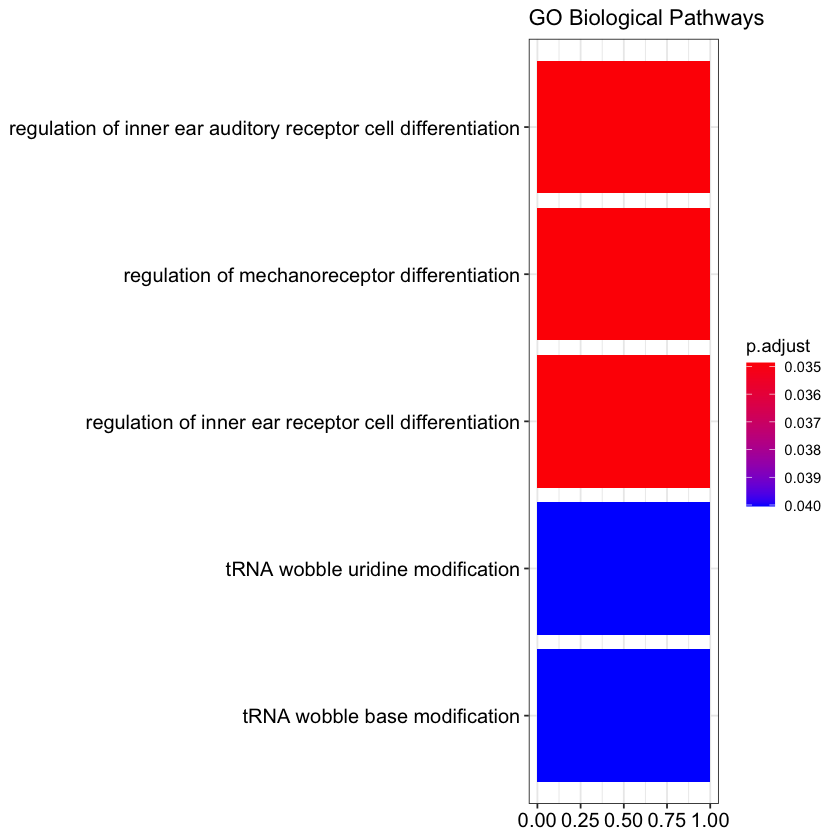

In [11]:
# Gene Ontology enrichment for biological pathways

go <- enrichGO(gene_names, OrgDb = 'org.Hs.eg.db', keyType = 'ENSEMBL', readable = T, ont = 'BP')
barplot(go, drop = T, showCategory = 5, title = "GO Biological Pathways", font.size = 12)

Reading KEGG annotation online:


Reading KEGG annotation online:


'select()' returned 1:1 mapping between keys and columns

Info: Working in directory /Users/jonatan/Desktop/RNA_seq_pipe

Info: Writing image file hsa00250.pathview.png



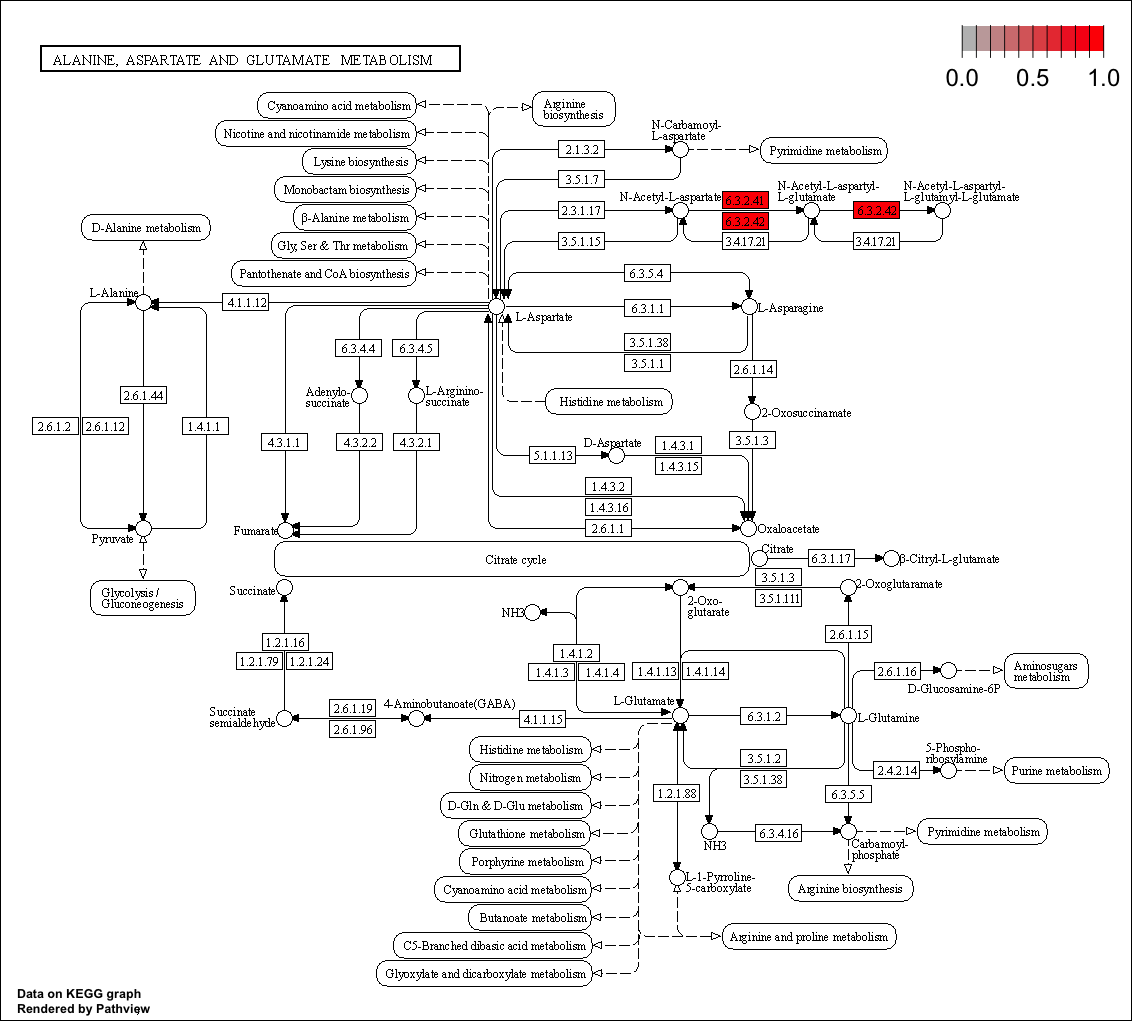

In [12]:
# KEGG pathway enrichment analysis

kegg <- enrichKEGG(gene = entrez_ids$ENTREZID, organism = 'hsa')
pv.out <- pathview(gene.data = entrez_ids$ENTREZID, pathway.id = kegg$ID, species = 'hsa')
display_png(file="./hsa00250.pathview.png", width = 900, height = 900)

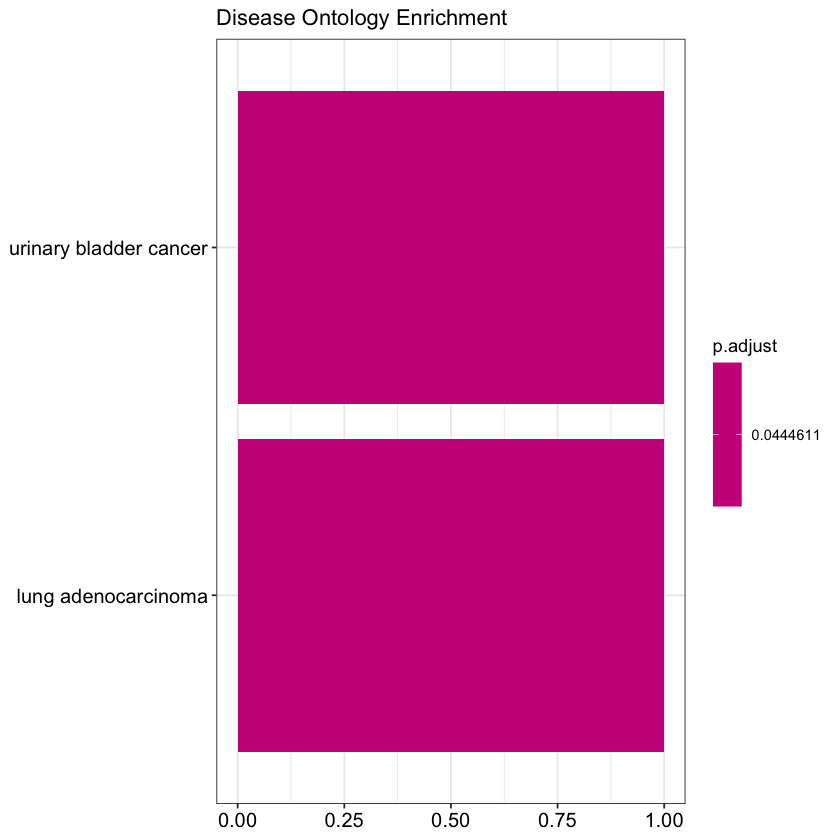

In [13]:
# Enrichment for disease ontology

do <- enrichDO(gene = entrez_ids$ENTREZID, ont = 'DO', readable = T)
barplot(do, title = 'Disease Ontology Enrichment')